In [1]:
# from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
import IPython.core.display as di
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code on/off</button>''', raw=True)

Toggle code on/off

# Random Forest Classifier Training

This notebook:
- takes in all the March-May 2019 summiting experiments, 
- leaves one experiment out for testing, 
- generates data vectors (details illustrated in `data_processing_overview.ipynb`) from all the experiments
- splits them up into training and validation sets
- sets data processing parameters (used for training a model and for processing new data into something the classifier can operate on)
- trains a classifier
- assesses performance on validation data
- saves data processing parameters and the classifier itself (`params` and `clf`)

Things one can tweak to affect model performance:
- the parameters in "Data processing parameters" (to adjust the data vectors, i.e. what the classifier sees/operates on)
- the arguments in RandomForestClassifier

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import sys; sys.path.append('..')
from utils.load_data_utils import get_data_from_exp_dir
from utils.classifier_plot_utils import  plot_confusion, \
    plot_feature_vec, plot_feature_importances, state_colors, set_font_sizes
from utils.process_data_utils import make_X_y_from_expmt, get_fprs_tprs_aucs
import pickle 
import os
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import preprocessing
import seaborn as sns
set_font_sizes()

C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
saveto_dir = '../models/'
save_model = False
if save_model:
    save_tag = 'example_classifier_model' # what to add to filename of clf.p, params.p to make it distinct

In [4]:
save_figs = True
figure_plot_dir = 'train_random_forest_figures'
if save_figs:
    if not os.path.isdir(figure_plot_dir):
        os.makedirs(figure_plot_dir)

### Data processing parameters

Set parameters dictating how to generate data vectors (duration to consider "current" behavior, number of frames for "current"/"previous" behavior, whether to do moving average, etc.)

These haven't been tweaked systematically, but here's the general sense I've gotten:

- 20/10 frames for current/previous activity seems sufficient for the random forest classifier
- 200 examples per trajectory (meaning partition each observed ROI into 200 examples to give more examples to the classifier) seems sufficient (much less and the classifier won't see as many instances of the different classes, and much more doesn't seem to help performance)
- for each frame, taking an average over a small time window (what I've been calling "moving average") helps performance. I've been doing a window of 10 minutes -- using < 1 minute isn't so good
- log spacing for previous frames seems to perform better than uniform spacing (more opportunity to pick up fast speeds during summiting)

In [5]:
# tweakable data processing parameters
params = {}

# modify these as desired
params['CURR_WINDOW_WIDTH'] = int(10*60*3)   # length of time to define "current" time window (in frames)
params['NCURR'] = 20                         # number of frames in the "current" time window
params['NPREV'] = 10                         # number of frames in the "present" time window
params['LOG_SPACING'] = True                 # option to take logarithmically spaced previous frames (otherwise uniform)
params['PREV_LB'] = 1000                     # minimum frame to make examples of
params['EX_PER_TRAJ'] = 200                  # number of training/validation examples per trajectory
params['MIN_LOCAL_TIME'] = 24                # start time of classification/training (summiting doesn't happen before this)
params['do_mov_avg'] = True                  # option to take moving average of ypos, spd (or: independent frames)
params['wl'] = int(10*60*3)                  # window length for moving average (in frames)
params['normalize_features'] = False         # option to normalize all X features (mean 0, var 1) (doesn't seem to help)
params['do_continuous'] = False              # EXPERIMENTAL: try a continuous time-to-summiting output

# convenient indexing
params['num_features'] = 2*(params['NCURR'] + params['NPREV']) + 1
pn = params['NPREV']; cn = params['NCURR']
params['i_ypos_prev'] = np.arange(1, pn+1)
params['i_ypos_curr'] = np.arange(pn+1, pn+cn+1)
params['i_spd_prev'] = np.arange(pn+cn+1, 2*pn+cn+1)
params['i_spd_curr'] = np.arange(2*pn+cn+1, 2*pn+2*cn+1)

## Load in Data

- List all of the available data directories for training/validation, leaving one out for testing (to run a mock live classifier). 
- Then, take each trajectory and split it up into `params['EX_PER_TRAJ']` randomly chosen frames
- For each frame, make a data vector $X_i = \bigg(\underbrace{time}_{current},\underbrace{ypos, \dots, ypos}_{previous},\underbrace{ypos, \dots, ypos}_{current},\underbrace{speed, \dots, speed}_{previous},\underbrace{speed, \dots, speed}_{current} \bigg)$ and outcome $y_i \in \{\mathrm{alive,~pre~summit,~during~summit,~post~summit}\}$ (as explained in the `data_processing_overview` notebook)
- Split the data into 75% training and 25% validation

In [6]:
all_dirs = [
    #'../Behavior_data/07-25-2018-15-10-22__Circadian_Cs WF_MF_E. muscae_1-128_Day3/',
    r'03-22-2019-18-21-01__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day3/',
    r'03-22-2019-18-37-18__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3/',
    r'03-23-2019-18-32-19__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day4/',
    r'03-23-2019-18-35-30__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day4/',
    r'04-04-2019-18-59-55__Circadian_Cs_WF_exp_MF_Emuscae_1-128_Day1/',
    r'04-05-2019-21-14-39__Circadian_CsWF-BoardC4_MF_Emuscae_1-128_Day4/',
    r'04-05-2019-21-17-24__Circadian_CsWF-BoardC14_MF_Emuscae_1-128_Day4/',
    r'04-06-2019-20-16-55__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day4/',
    r'04-11-2019-19-32-45__Circadian_CsWF-BoardC12_MF_Emuscae_1-128_Day4/',
    r'04-15-2019-18-00-15__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day3/',
    r'04-15-2019-18-03-17__Circadian_CsWF-BoardC2_MF_Emuscae_1-128_Day3/',
    r'04-16-2019-18-04-50__Circadian_CsWF-BoardC2_MF_Emuscae_1-128_Day4/',
    r'04-16-2019-18-10-44__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day4/',
    r'04-21-2019-20-51-44__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3/',
    r'05-09-2019-17-48-12__Circadian_Ethology-CsWF-BoardC10_MF_Emuscae_1-128_Day3/'    
]

behavior_data_dir = '../../Data/Data by figure/Fig 4 + Supp/'
all_dirs = [os.path.join(behavior_data_dir, x) for x in all_dirs]
held_out_pos = 13 #np.random.randint(len(all_dirs))

test_dirs = [all_dirs[held_out_pos]]
data_dirs = all_dirs[:held_out_pos] + all_dirs[(held_out_pos+1):]

In [7]:
frac_val = 0.25 # proportion of data to hold out as validation

np.random.seed(1234)

# initialize training, validation data
data_X = np.zeros((0, params['num_features']))
data_y = np.zeros((0,))
test_X = np.zeros((0, params['num_features']))
test_y = np.zeros((0,))

# load in data into necessary form
log_cols = ['expmt', 'ROI', 'frame', 'y', 'type']
roi_log_df = pd.DataFrame(columns=log_cols)

print('Loading data:')
for d_dir in data_dirs:
    print('\tReading in {}'.format(d_dir))
    # fix long filenames issue
    d_dir = '\\\\?\\'+os.path.abspath(d_dir)
    # retrieve experiment flies
    d_ed, d_df = get_data_from_exp_dir(d_dir)  
    d_x, d_y, d_log = make_X_y_from_expmt(d_ed, d_df, params)
    mask = np.all(np.isnan(d_x), axis=1)
    d_x = d_x[~mask]; d_y = d_y[~mask]; d_log = d_log[~mask]
    expmt_log_df = pd.DataFrame(np.column_stack((
         [d_dir]*len(d_y), np.array(d_log), d_y, ['train']*len(d_y))), 
         columns=log_cols)
    
    # assign certain flies to be train/val flies
    exp_nroi = d_df.shape[0]
    chosen_val_ROIs = np.random.choice(np.arange(exp_nroi), int(frac_val*exp_nroi), replace=False)+1
    expmt_log_df.loc[expmt_log_df['ROI'].astype(int).isin(chosen_val_ROIs), 'type'] = 'val'
    
    # concatenate all data
    data_X = np.concatenate((data_X, d_x))
    data_y = np.concatenate((data_y, d_y))
    roi_log_df = pd.concat((roi_log_df, expmt_log_df))

Loading data:
	Reading in ../../Data/Data by figure/Fig 4 + Supp/03-22-2019-18-21-01__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day3/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/03-22-2019-18-37-18__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/03-23-2019-18-32-19__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/03-23-2019-18-35-30__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/04-04-2019-18-59-55__Circadian_Cs_WF_exp_MF_Emuscae_1-128_Day1/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/04-05-2019-21-14-39__Circadian_CsWF-BoardC4_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/04-05-2019-21-17-24__Circadian_CsWF-BoardC14_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/04-06-2019-20-16-55__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4

In [8]:
df_included_rois = (roi_log_df
 .replace(['dur', 'post', 'pre'], 'cadaver')
 .groupby(['expmt', 'ROI', 'y']).count()
 .reset_index()
 .groupby(['expmt', 'y']).count()
 .reset_index()
 .pivot('expmt', 'y', 'ROI')
 #.reset_index()
)
df_included_rois

y,Alive,cadaver
expmt,,
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\03-22-2019-18-21-01__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day3,95,5
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\03-22-2019-18-37-18__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3,113,9
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\03-23-2019-18-32-19__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day4,55,26
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\03-23-2019-18-35-30__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day4,73,31
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\04-04-2019-18-59-55__Circadian_Cs_WF_exp_MF_Emuscae_1-128_Day1,45,73
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\04-05-2019-21-14-39__Circadian_CsWF-BoardC4_MF_Emuscae_1-128_Day4,23,21
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\04-05-2019-21-17-24__Circadian_CsWF-BoardC14_MF_Emuscae_1-128_Day4,13,38
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\04-06-2019-20-16-55__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day4,16,16
\\?\D:\Summit paper data\Data\Data by figure\Fig 4 + Supp\04-11-2019-19-32-45__Circadian_CsWF-BoardC12_MF_Emuscae_1-128_Day4,24,30


In [9]:
df_included_rois.sum()

y
Alive      961
cadaver    345
dtype: int64

In [10]:
split_on_flies = False
if split_on_flies:
    # roi_log_df.drop_duplicates(['expmt', 'ROI'])['type'].value_counts()
    grand_train_is = np.where(roi_log_df['type'] == 'train')[0]
    grand_val_is = np.where(roi_log_df['type'] == 'val')[0]
    
    train_X = data_X[grand_train_is]
    val_X = data_X[grand_val_is]
    train_y = data_y[grand_train_is]
    val_y = data_y[grand_val_is]

else:
    trainfrac = 0.75
    train_X, val_X, train_y, val_y = train_test_split(data_X, data_y, test_size=1-trainfrac, random_state=1234)

## Glance at training data features

In [11]:
# find locations of classes in training, validation data:
train_alives = np.where(train_y == 'Alive')[0]; n_train_alive = len(train_alives)
train_pres = np.where(train_y == 'pre')[0]; n_train_pre = len(train_pres)
train_durs = np.where(train_y == 'dur')[0]; n_train_dur = len(train_durs)
train_posts = np.where(train_y == 'post')[0]; n_train_post = len(train_posts)
val_alives = np.where(val_y == 'Alive')[0]; n_val_alive = len(val_alives)
val_pres = np.where(val_y == 'pre')[0]; n_val_pre = len(val_pres)
val_durs = np.where(val_y == 'dur')[0]; n_val_dur = len(val_durs)
val_posts = np.where(val_y == 'post')[0]; n_val_post = len(val_posts)

# print out counts
class_counts = np.vstack((
    (n_train_alive, n_train_pre, n_train_dur, n_train_post),
    (n_val_alive, n_val_pre, n_val_dur, n_val_post)))
class_counts = np.hstack((class_counts, 
                          class_counts.sum(1).reshape(-1,1)))

print('Class counts per dataset:')
pd.DataFrame(class_counts,
            columns=['Alive', 'pre', 'dur', 'post', 'Total'],
            index=['training', 'validation'])

Class counts per dataset:


,Alive,pre,dur,post,Total
training,144123,33624,5212,12941,195900
validation,48077,11120,1690,4413,65300


In [12]:
if params['normalize_features']:
    std_scale = preprocessing.StandardScaler().fit(train_X) # find mean, std of train X
    train_X = std_scale.transform(train_X) # scale training X
    val_X = std_scale.transform(val_X) # and also scale validation X using training X

In [13]:
params_t = ['t']
params_yp = ['yp{}'.format(i) for i in range(params['NPREV'])]
params_yc = ['yc{}'.format(i) for i in range(params['NCURR'])]
params_sp = ['sp{}'.format(i) for i in range(params['NPREV'])]
params_sc = ['sc{}'.format(i) for i in range(params['NCURR'])]

param_names = params_t + params_yp + params_yc + params_sp + params_sc

In [14]:
mm_per_px_scaling = 0.31 * 3

train_X_speed_mm_s = train_X.copy()
train_X_speed_mm_s[:, params['i_spd_prev']] *= mm_per_px_scaling
train_X_speed_mm_s[:, params['i_spd_curr']] *= mm_per_px_scaling

sub_alive = train_X_speed_mm_s[train_alives]
sub_pre = train_X_speed_mm_s[train_pres]
sub_dur = train_X_speed_mm_s[train_durs]
sub_post = train_X_speed_mm_s[train_posts]

In [15]:
def make_grand_plot_df():
    df_alive = pd.DataFrame(sub_alive, columns=param_names).melt()
    df_pre = pd.DataFrame(sub_pre, columns=param_names).melt()
    df_dur = pd.DataFrame(sub_dur, columns=param_names).melt()
    df_post = pd.DataFrame(sub_post, columns=param_names).melt()
    
    df_alive['type'] = 'alive'; df_pre['type'] = 'pre'; df_dur['type'] = 'dur'; df_post['type'] = 'post'
    
    df_plot = pd.concat((df_alive, df_pre, df_dur, df_post))
    df_plot.reset_index(drop=True, inplace=True)
    
    return df_plot

df_grand = make_grand_plot_df()[::100]

In [16]:
df_grand.shape

(119499, 3)

C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dB\Anaconda3\envs\

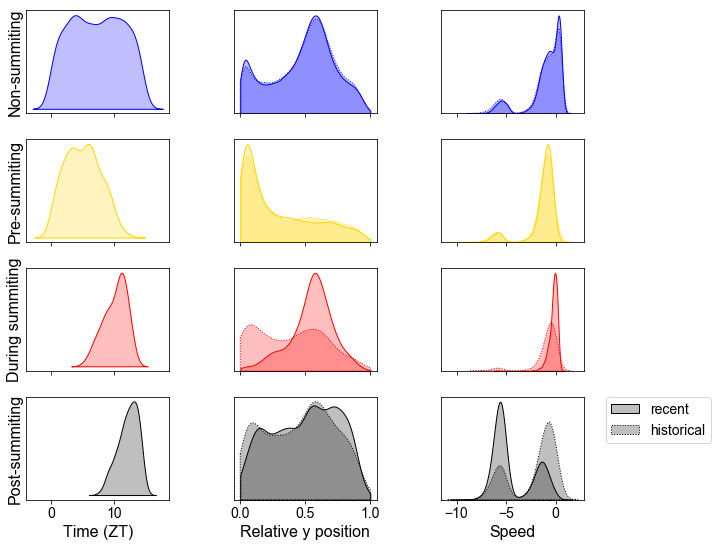

In [17]:
fig, axs = plt.subplots(4, 3, figsize=(10,9), sharex='col', facecolor='white')

do_log_speed = 1
order = ['alive', 'pre', 'dur', 'post']
fl_order = ['Non-summiting', 'Pre-summiting', 'During summiting', 'Post-summiting']

palette = [state_colors['Alive'], state_colors['pre'], state_colors['dur'], state_colors['post']]

for i in range(4):
    cur_class = order[i]
    
    
    class_df = df_grand[df_grand['type'] == cur_class]
    class_df['historical'] = class_df['variable'].str.contains('p')
    
    t_class_df = class_df[class_df['variable'] == 't']
    ypos_class_df = class_df[class_df['variable'].str.contains('y')]
    speed_class_df = class_df[class_df['variable'].str.contains('s')]
    
    if do_log_speed:
        speed_class_df.loc[:, 'value'] = np.log10(speed_class_df['value'])
        speed_class_df.loc[np.isfinite(speed_class_df['value'])].dropna()
        
    # plot time
    sns.kdeplot(t_class_df['value']-24, color=palette[i], fill=True,
                ax=axs[i, 0])
    
    # plot ypos
    p = sns.kdeplot(x='value', hue='historical', palette=[palette[i]]*2, fill=True,
                ax=axs[i, 1], clip=[0,1], data=ypos_class_df, common_norm=False)
    
    # from https://stackoverflow.com/questions/70089199/how-to-set-a-different-linestyle-for-each-hue-group-in-a-kdeplot-displot
    lss = [':', '-']#, '-.', '-']
    handles = p.legend_.legendHandles[::-1]
    for line, ls, handle in zip(p.collections, lss, handles):
        line.set_linestyle(ls)
        handle.set_ls(ls)
    
    # plot speed
    s = sns.kdeplot(x='value', hue='historical', palette=[palette[i]]*2, fill=True,
                ax=axs[i, 2], data=speed_class_df, common_norm=False)
    
    axs[i, 2].legend(['recent', 'historical'], loc='upper left', bbox_to_anchor=(1.15, 1), borderaxespad=0)
    
    handles = s.legend_.legendHandles[::-1]
    for line, ls, handle in zip(s.collections, lss, handles):
        line.set_linestyle(ls)
        handle.set_ls(ls)
    
    for j in range(3):
        ax = axs[i, j]
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel('')
        if j > 0:
            
            if not( (j == 2) and (i == 3) ):
                ax.get_legend().remove()
            else:
                0#ax.legend(loc='upper left', bbox_to_anchor=(1.025, 1), borderaxespad=0)
        
    axs[i, 0].set_ylabel(fl_order[i])
        
axs[-1, 0].set_xlabel('Time (ZT)')
axs[-1, 1].set_xlabel('Relative y position')
axs[-1, 2].set_xlabel('Speed')

plt.subplots_adjust(wspace=0.45, hspace=0.25)

if save_figs:
    plt.savefig(os.path.join(figure_plot_dir,'fig_classifier_sup_kdes.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(figure_plot_dir,'fig_classifier_sup_kdes.png'), dpi=250, bbox_inches='tight')
plt.show()

This is what the training data looks like -- the "during" flies have a sustained high speed in the current time window, and have a rather distinct y pos profile compared to the other states.

## Random Forest Classifier

Now we just feed in our training data to scikit-learn's RandomForestClassifier.

From scikit-learn:

"A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default)."

Again the model parameters weren't tweaked systematically, but my general sense is:
- `criterion = "gini"` (what's used to evaluate data splits) performs much better than `criterion = "entropy"`
- `n_estimators` (the number of decision trees) should be in the ballpark of 100 (much less and you'll overfit to training data, and much more is just a lot of time)
- `max_depth` is the maximum depth of a tree. Set this too high and you'll overfit to training data (with more "yes/no questions" you'll fit to quirks in the training data that won't generalize well)
- `min_samples_leaf` and `min_samples_split` are both set to 10 -- setting them too low is similar to making a really deep tree, which doesn't generalize well

### reading in trained model / training a new model

All classifier experiments used the following model files:
- `models/clf_used_in_experiments.p`
- `models/params_used_in_experiments.p`

If `save_model` is set to False, then the following cells will read in that trained model used for experiments and evaluate model performance on validation data to generate Figs 4C-D and 4-S1A.

If `save_model` is set to True, then a new model will be trained and saved to `models/`.

In [18]:
TRAIN_X = np.copy(train_X)
TRAIN_Y = np.copy(train_y)
VAL_X = np.copy(val_X)
VAL_Y = np.copy(val_y)

labs = ['Alive', 'pre', 'dur', 'post']
lab_is = dict((c, i) for i, c in enumerate(labs))
lab_itolabs = dict((i, c) for i, c in enumerate(labs))

In [19]:
if save_model:
    t0 = time.time()

    clf = RandomForestClassifier(
            random_state=1234,
            n_estimators = 100,
            min_samples_leaf = 10,
            min_samples_split = 10,
            max_depth = 15,
            criterion = "gini")

    # fit model
    clf.fit(TRAIN_X, TRAIN_Y)

    # time it
    tf = time.time()
    print('Took {:.2f} sec to train'.format(tf - t0))
else:
    experiment_clf_fpath = '../models/clf_used_in_experiments.p'
    clf = pickle.load(open(experiment_clf_fpath, "rb" ))

# know which indices correspond to classes
dic_class_to_i = dict((y,x) for (x,y) in enumerate(clf.classes_))
dic_i_to_class = dict((x,y) for (x,y) in enumerate(clf.classes_))

In [20]:
# compute errors
train_err = sum(clf.predict(TRAIN_X) != TRAIN_Y) / len(TRAIN_Y)
val_err = sum(clf.predict(VAL_X) != VAL_Y) / len(VAL_Y)
print('train err: {:.5f}, train val: {:.5f}'.format(train_err, val_err))

train err: 0.09726, train val: 0.09729


In [21]:
# compute errors
train_err = sum(clf.predict(TRAIN_X) != TRAIN_Y) / len(TRAIN_Y)
val_err = sum(clf.predict(VAL_X) != VAL_Y) / len(VAL_Y)
print('train err: {:.5f}, train val: {:.5f}'.format(train_err, val_err))

train err: 0.09726, train val: 0.09729


### tree

Visualization of first tree in trained forest

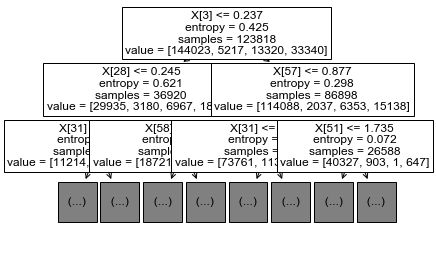

In [22]:
from sklearn.tree import plot_tree

estimator = clf.estimators_[0]

plt.figure()
plot_tree(estimator, max_depth=2, fontsize=12)
plt.show()

## Model performance on validation data and characteristics

(Figure 4-S1A)

We left out 25% of the data vectors as a validation set. Let's feed them into the classifier, see what it spits out for each one, and record what the predicted/true label was:

In [23]:
VAL_Y

array(['pre', 'Alive', 'Alive', ..., 'pre', 'Alive', 'pre'], dtype='<U32')

In [24]:
def replace_class_labels(x):
    rx = np.char.replace(x, 'Alive', 'non-')
    rx = np.char.replace(rx, 'dur', 'during')
    rx = np.char.replace(rx, 'pre', 'pre-')
    rx = np.char.replace(rx, 'post', 'post-')
    return rx

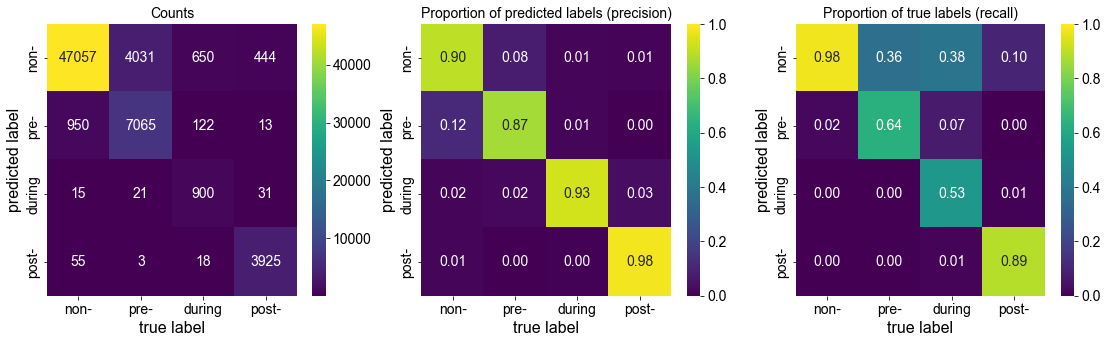

In [25]:
set_font_sizes()

# compute precision, recall
y_pred = clf.predict(VAL_X)
y_true = VAL_Y

plt.figure(figsize=(19,5))

cm_df = plot_confusion(replace_class_labels(y_pred), 
                       replace_class_labels(y_true), 
                       ['non-', 'pre-', 'during', 'post-'])

plt.subplots_adjust(wspace=0.2)

if save_figs:
    plt.savefig(os.path.join(figure_plot_dir, 'classifier_validation_confusion_matrix.png'), bbox_inches='tight',dpi=300)
    plt.savefig(os.path.join(figure_plot_dir, 'classifier_validation_confusion_matrix.pdf'), bbox_inches='tight')

plt.show()

Consistent with what one would expect, post-summiting is the easiest to classify, while pre- and alive- can be easily confused for one another.

The "dur-" precision (given motion data up to time $t$, and then converting it to a data vector encompassing local time and current/previous behavior, if $t$ is truly during summiting, how often did the classifier label it as during summiting? i.e. of the data that is labelled as summiting, what percent truly are summiting?) is what is most important to optimize. It's at ~90%, and I haven't seen any parameter combinations giving anything much higher. 

The "dur-" recall answers how often the truly during-summiting data are labelled by the classifier as during-summiting. It's at ~50%, again which is the best I've gotten it to be (admittedly, without a sweeping, systematic search through model/data processing parameters!)

These numbers are pretty good if we want at least 20 summiting flies for hemolymph testing. If we have a board of 128 chambers, and if 60 flies will truly succumb to the fungus in the day of observation, then we'd expect ~50% to be captured by the classifier as summiting, and of those, 90% will be truly summiting, giving about ~25 summiting flies.

However, note that in real-time data collection, we can make multiple evaluations of the state of an ROI and ultimately make a decision based on aggregate information (for instance, we can call a fly as summiting if it has been classified as during-summiting for 4 straight minutes). With decision rules based on multiple evaluations, precision/recall could go up, so we're not exactly limited to the numbers here. For consequences of different rules, the next file to look at is `test_classification.ipynb`.

In [26]:
# more info
print(classification_report(y_true, y_pred, labels=labs))

              precision    recall  f1-score   support

       Alive       0.90      0.98      0.94     48077
         pre       0.87      0.64      0.73     11120
         dur       0.93      0.53      0.68      1690
        post       0.98      0.89      0.93      4413

    accuracy                           0.90     65300
   macro avg       0.92      0.76      0.82     65300
weighted avg       0.90      0.90      0.90     65300



The ROC curves:

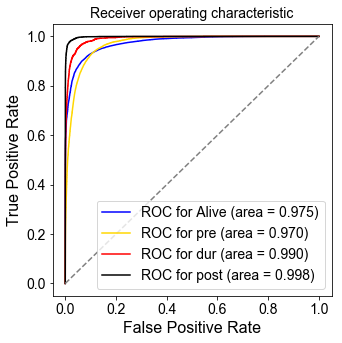

In [27]:
fprs, tprs, aucs = get_fprs_tprs_aucs(clf, VAL_X, VAL_Y, labs, dic_class_to_i)
plt.figure(figsize=(5,5))
for i in range(len(labs)):
    plt.plot(fprs[i], tprs[i], color=state_colors[labs[i]],
             label='ROC for {} (area = {:.3f})'.format(labs[i], aucs[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend()
if save_figs:
    plt.savefig(os.path.join(figure_plot_dir, 'classifier_ROC.png'), bbox_inches='tight',dpi=300)
    plt.savefig(os.path.join(figure_plot_dir, 'classifier_ROC.pdf'), bbox_inches='tight')

plt.show()

## feature importances

(Figure 4C)

In [28]:
from matplotlib.lines import Line2D
def plot_feature_importances(featimp, params):
    # set up colors, legend
    feat_colors = np.array(['default_color']*params['num_features'])
    feat_colors[0] = 'black'
    feat_colors[params['i_ypos_prev']] = 'red'
    feat_colors[params['i_ypos_curr']] = 'orange'
    feat_colors[params['i_spd_prev']] = 'green'
    feat_colors[params['i_spd_curr']] = 'violet'

    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Zeitgeber time', markerfacecolor='black'),
                       Line2D([0], [0], marker='o', color='w', label='y position (historical)', markerfacecolor='red'),
                       Line2D([0], [0], marker='o', color='w', label='y position (recent)', markerfacecolor='orange'),
                       Line2D([0], [0], marker='o', color='w', label='speed (historical)', markerfacecolor='green'),
                       Line2D([0], [0], marker='o', color='w', label='speed (recent)', markerfacecolor='violet')]
    
    # plot
    #plt.figure()
    ax = plt.subplot(111)
    plt.scatter(np.arange(len(featimp)), featimp, color=feat_colors)
    ax.set_xlabel('feature index')
    ax.set_ylabel('feature importance')
    plt.legend(handles=legend_elements, title='feature type', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    #plt.show()

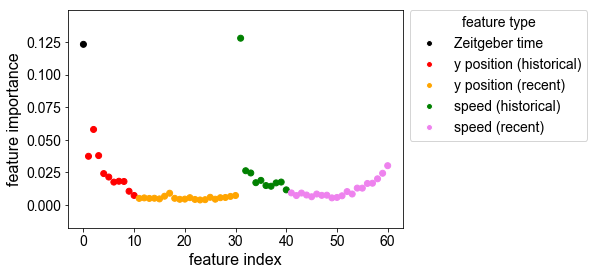

In [29]:
plt.figure()
plot_feature_importances(clf.feature_importances_, params)
#plt.title('Feature Importances')
if save_figs:
    plt.savefig(os.path.join(figure_plot_dir, 'feature_importances.png'), bbox_inches='tight',dpi=300)
    plt.savefig(os.path.join(figure_plot_dir, 'feature_importances.pdf'), bbox_inches='tight')
plt.show()

### plotting salient features

(Figure 4D)

In [30]:
def make_plot_df(col_name, offset=0):
    col_i = np.where(np.array(param_names) == col_name)[0]
    df_alive = pd.DataFrame(sub_alive[:, col_i]-offset, columns=[col_name])
    df_pre = pd.DataFrame(sub_pre[:, col_i]-offset, columns=[col_name])
    df_dur = pd.DataFrame(sub_dur[:, col_i]-offset, columns=[col_name])
    df_post = pd.DataFrame(sub_post[:, col_i]-offset, columns=[col_name])
    df_alive['type'] = 'alive'; df_pre['type'] = 'pre'; df_dur['type'] = 'dur'; df_post['type'] = 'post'

    df_plot = pd.concat((df_alive, df_pre, df_dur, df_post))
    df_plot.reset_index(drop=True, inplace=True)
    
    #if 's' in cur_param:
    #    df_plot.loc[:, cur_param] = df_plot[cur_param] * 0.31 * 3
        
    return df_plot

C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


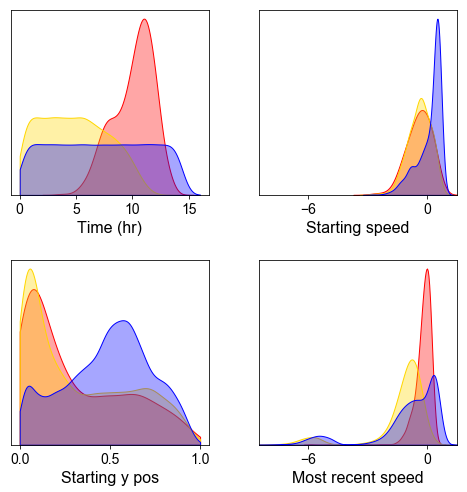

In [31]:
plot_params = ['t', 
               'sp0', 
               'yp1',               
               'sc19']
labels=['Time (hr)',
        'Starting speed',
        'Starting y pos',
        'Most recent speed']


n_plots = len(plot_params)
fig, axs = plt.subplots(2,2, figsize=(8,8), facecolor='white')

do_log_speed = 1
order = ['alive', 'pre', 'dur', 'post']
palette = [state_colors['Alive'], state_colors['pre'], state_colors['dur'], state_colors['post']]

bw = 1.5
clips = [[0, 16], [-8.5, 1.5],
         [0, 1], [-8.5, 1.5]]
         
         
for i in range(n_plots):
    
    cur_ax = axs[i // 2, i % 2]
    
    cur_param = plot_params[i]
    df_plot = make_plot_df(cur_param, offset=24*(cur_param == 't'))
    df_plot.reset_index(drop=True, inplace=True)
    
    df_plot = df_plot[df_plot.type.isin(['alive', 'pre', 'dur'])]
    if do_log_speed:
        if 's' in cur_param:
            df_plot.loc[:, cur_param] = np.log10(df_plot[cur_param])
            
    sns.kdeplot(x=cur_param,
                 hue='type',
                 data=df_plot, 
                 multiple='layer',
                 alpha=0.35,
                 #element='step',
                 #stat='density',
                 bw_adjust=bw + bw*(cur_param == 'sp0'),
                 fill=True,
                 palette=palette[:3], 
                 legend=False, 
                 ax = cur_ax, 
                 clip = clips[i],
                 common_norm=False
               )
        
    cur_ax.set_ylabel('')
    cur_ax.get_yaxis().set_ticks([])
    cur_ax.set_xlabel(labels[i])
    if cur_param in ['sp0', 'sc19']:
        cur_ax.set_xlim(-8.5, 1.5)
        cur_ax.get_xaxis().set_ticks([-6, 0])
    
#axs[-1].set_ylim(-0.25, 4.25)
#axs[0].set_ylabel('proportion')
plt.subplots_adjust(wspace=0.25, hspace=0.35)  
if save_figs:
    plt.savefig(os.path.join(figure_plot_dir, 'fig4_classifier_salient_features.pdf'), bbox_inches='tight')
    plt.savefig(os.path.join(figure_plot_dir, 'fig4_classifier_salient_features.png'), bbox_inches='tight', dpi=300)
plt.show()

### saving model

In [32]:
if save_model:
    pickle.dump(params, open(os.path.join(saveto_dir, "params_{}.p".format(save_tag)), "wb" ))
    pickle.dump(clf, open(os.path.join(saveto_dir, "clf_{}.p".format(save_tag)), "wb" ))

Yay, we've trained a classifier. One can tinker with data processing parameters (`params`) that will affect what the data vectorization looks like (which you must use for future data that you want your classifier to classify on) and RandomForestClassifier arguments to affect the model.

The next step is to see how this classifier runs on completely unseen data (the April 21 dataset) and what different decision rules on calling summiting flies look like in practice: `test_classification.ipynb`.